# How much of the total time of each report is related to querying the data?

>Questions being answered in this notebook.
>- [x] How much of the total time of each report is related to performance?



[THIS ANALYSIS IS NOT COMPLETED]

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
active_and_problematics = pd.read_csv("../../datasets/actives_and_problematics_regarding_time_last_30_days_from-27-07-2022.csv")

In [3]:
active_and_problematics.drop("ReportId", axis=1, inplace=True)
#Record id is Report id derived
active_and_problematics.rename(columns={"RecordId": "ReportId"}, inplace=True)

In [4]:
interest_cols = {
    'Name': "first",
    "ReportId": "first",
    "Description": "first",
    "DurationInMinutes": ["min", "max", "median", "mean", "std", "count"],
    'RowsProcessed': ["sum", "min", "max", "median", "mean", "std"],
    "RowsReturned": ["first", "unique", "count"],
    'ConnectionType': ["first", "unique", "count"],
    'ColumnHeaders': ["first", "unique", "count"], 
    'DashboardId': "first",
    'DashboardName': "first",
    'Format': "first", 
    'GroupedColumnHeaders': ["first", "unique"],
    "OperationType": ["first", "unique", "count"],
    'OsName': ["first", "unique", "count"], 
    'OsVersion': ["first", "unique", "count"],
    'PageStartTime': ["first", "unique"],
    'PageUrl': ["first", "unique", "count"],
    'PreviousPageAppName': ["first", "unique", "count"],
    'PreviousPageEntityType': ["first", "unique", "count"], 
    'PreviousPageUrl': ["first", "unique", "count"],
    'DisplayedFieldEntities': ["first", "unique", "count"],
    'EvaluationTime': ["first", "unique", "count"],
    'DeviceModel': ["first", "unique", "count"], 
    'DevicePlatform': ["first", "unique", "count"]
}



In [5]:
summary = active_and_problematics[list(interest_cols.keys())]\
    .groupby("Name")\
    .agg({k: v for k, v in interest_cols.items() if k!="Name"})\
    .reset_index()

In [6]:
new_column_names = []
for k, v in zip(summary.columns.get_level_values(0), summary.columns.get_level_values(1)):
    columnName = k + ("" if v=="first" else v.capitalize())
    new_column_names.append(columnName)


In [7]:
summary.columns = new_column_names

In [9]:
summary.to_csv("actives_and_problematics_summary.csv")

In [10]:
problematic_reports = list(summary.ReportId)

In [11]:
problematic_reports

['00O6P000000yX5NUAU',
 '00O0b000004AoOOEA0',
 '00O2R000003JQyNUAW',
 '00O6P000000VF5IUAW',
 '00O6P000001B8LVUA0',
 '00O0b000004kTazEAE',
 '00O2R000004Am1WUAS',
 '00O2R000004IlyzUAC']

In [12]:
import re

pattern = re.compile(r'\/lightning\/r\/(?P<report_type>[a-zA-Z]{4,})\/(?P<report_id>[0-9a-zA-Z]{18})')

def filter_run_report_endpoints(pattern, field, url):
    m = re.match(pattern, url)
    if m:
        return m.group(field)

In [15]:
from collections import defaultdict

logdate = ['2022-06-28', "2022-07-05", "2022-07-11", "2022-07-22", "2022-07-27"]
logs = ["Dashboard", "LightningPageView", "LightningPerformance", "LightningError", "Report"]

# used to infer report id over performance logs
common_subset_features = ['USER_ID', 'USER_ID_DERIVED', 'SESSION_KEY', 'LOGIN_KEY', 'ORGANIZATION_ID', 'CLIENT_IP']

verbose = False
chunk_size = 10000

logdf = defaultdict(dict)
for d in logdate:
    for ltng_log in logs: 
        for f in os.listdir(d):
            if f"{ltng_log}_chunk" in f:
                df_iter = pd.read_csv(os.path.join(d, f), chunksize=chunk_size)
                for i, chunk in enumerate(df_iter):
                    if verbose:
                        print("Loading chunk", i+1, "from", ltng_log)
                    tmp = chunk.copy()
                    if ltng_log in [logs[1], logs[3]]:
                        tmp.dropna(subset=["PAGE_URL"], inplace=True)
                        tmp["ReportId"] = tmp.PAGE_URL.apply(lambda url: filter_run_report_endpoints(pattern, "report_id", url))
                        tmp["ReportType"] = tmp.PAGE_URL.apply(lambda url: filter_run_report_endpoints(pattern, "report_type", url))
                        tmp.dropna(subset=["ReportId"], inplace=True)
                    elif ltng_log in [logs[0], logs[4]]: # Dashboards and Reports
                        tmp.rename(columns={"REPORT_ID_DERIVED": "ReportId"}, inplace=True)
                    elif ltng_log == logs[2]: #LightningPerformance logs
                        # needs to extract report id using a common_subset_features
                        tmp["ReportId"] = None
                        pass
                    
                    if not "ReportId" in list(tmp.columns):
                        continue
                    
                    tmp = tmp[tmp.ReportId.apply(lambda report_id: report_id in problematic_reports)]
                    if verbose:
                        print("found", tmp.shape[0], " logs related")
                        
                    if ltng_log in logdf:
                        logdf[ltng_log] = pd.concat((logdf[ltng_log], tmp), axis=0)
                    else:
                        logdf[ltng_log] = tmp

---
## Merging Lightning Logs(PageView) and Problematics

In [16]:
logdf.keys()

dict_keys(['Dashboard', 'LightningPageView', 'LightningPerformance', 'LightningError', 'Report'])

Let's just get the Page view information and merge it with the reports from our data set

In [17]:
lgtn_reports = pd.merge(left=summary, right=logdf['LightningPageView'], on="ReportId")

In [18]:
lgtn_reports.shape

(12210, 115)

Let's take the time related columns

In [20]:
interest_columns = ['ReportId','Name', 
                    'DurationInMinutesMin', 
                    'DurationInMinutesMax',
                    'DurationInMinutesMedian',
                    'DurationInMinutesCount']

In [23]:
lgtn_reports = lgtn_reports[interest_columns]

In [24]:
lgtn_reports.shape

(12210, 6)

---
## Analyzing Durations

Let's get the reports with maximum duration

In [52]:
max_report_duration = lgtn_reports.nlargest(1, 'DurationInMinutesMax').DurationInMinutesMax
min_report_duration = lgtn_reports.nsmallest(1, 'DurationInMinutesMin').DurationInMinutesMin
max_and_min_report_duration = (min_report_duration.values[0], max_report_duration.values[0])

In [60]:
print(f"The minimum and maximum duration in minutes of reports are: Min {max_and_min_report_duration[0]} and Max {max_and_min_report_duration[1]}")

The minimum and maximum duration in minutes of reports are: Min 1.3858833333333334 and Max 10.712


Let's remove the other lines that only add information to our reports

In [132]:
unique_reports = lgtn_reports.drop_duplicates(keep='first')
unique_reports

,ReportId,Name,DurationInMinutesMin,DurationInMinutesMax,DurationInMinutesMedian,DurationInMinutesCount
0,00O6P000000yX5NUAU,AST Account Hierarchy Report,1.385883,1.385883,1.385883,1
124,00O0b000004AoOOEA0,Chat SLA - Wait Time,7.060517,7.060517,7.060517,1
404,00O6P000000VF5IUAW,EWS MICC & WO TL Nadiri,2.233383,3.337883,2.785633,2
410,00O0b000004kTazEAE,My Cases and Tasks,10.712000,10.712000,10.712000,1
11878,00O2R000004Am1WUAS,Parent Project Order Details,2.716267,2.716267,2.716267,1


Let's do the following steps:

> - [x] Group the data frame by name and average duration in minutes
> - [x] Calculate the total average duration in minutes of each report

In [133]:
total_duration_reports = unique_reports.groupby(['Name','DurationInMinutesMedian']).agg({'DurationInMinutesMedian': 'sum'})

In [134]:
total_duration_reports.rename(columns={'DurationInMinutesMedian': 'TotalTime'}, inplace=True)

In [135]:
total_duration_reports.reset_index(inplace=True)

total_duration_reports.drop(columns=['DurationInMinutesMedian'], inplace=True)

In [137]:
total_time_sorted = total_duration_reports.sort_values(by='TotalTime', ascending=False)

In [138]:
total_time_sorted

,Name,TotalTime
3,My Cases and Tasks,10.712000
1,Chat SLA - Wait Time,7.060517
2,EWS MICC & WO TL Nadiri,2.785633
4,Parent Project Order Details,2.716267
0,AST Account Hierarchy Report,1.385883


---
### Creeating a visualization

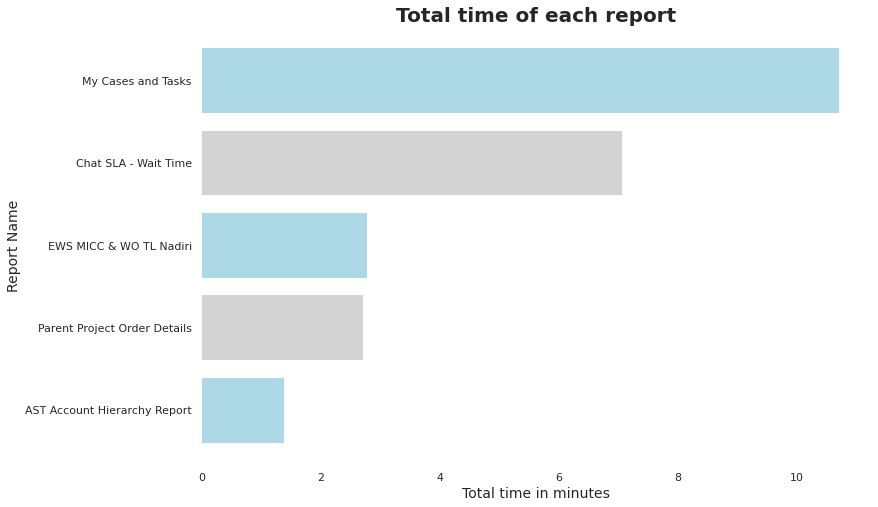

In [139]:
plt.figure(figsize=(12,8))


plt.barh(y = total_time_sorted['Name'], width = total_time_sorted['TotalTime'], color=['lightblue', 'lightgrey'])
plt.gca().invert_yaxis();
plt.xlabel('Total time in minutes', fontsize=14)
plt.ylabel('Report Name', fontsize=14)
plt.minorticks_on()
plt.grid(True, axis='x')
plt.title('Total time of each report', fontsize=20, fontweight="bold");

plt.rc('axes', axisbelow=True)
plt.box(on=None)

plt.show()